In [3]:
# 从 google.colab 库中导入 drive 模块
# 这个模块提供了与 Google Drive 交互的功能
from google.colab import drive
# 调用 drive 模块的 mount 方法将 Google Drive 挂载到 Colab 的虚拟机上
# '/content/gdrive' 是挂载的目标路径
# 执行这行代码会弹出一个授权提示，需要用户登录 Google 账号并授权访问 Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# 导入 copy 库，用于创建对象的副本
import copy
# 导入 random 库，用于生成随机数
import random
# 导入 pandas 库并简写为 pd，用于数据处理和分析
import pandas as pd
# 导入 numpy 库并简写为 np，用于数值计算
import numpy as np
# 导入 matplotlib.pyplot 库并简写为 plt，用于绘制图表
import matplotlib.pyplot as plt
# 导入 seaborn 库并简写为 sns，用于美化图表和统计数据可视化
import seaborn as sns
# 导入 torch 库，这是 PyTorch 深度学习框架的核心库
import torch
# 从 torch.nn 模块导入 nn，用于构建神经网络模型
from torch import nn
# 从 torch.optim 模块导入 optim，用于优化器
from torch import optim
# 从 sklearn.preprocessing 模块导入 MinMaxScaler，用于数据归一化
from sklearn.preprocessing import MinMaxScaler
# 下面两行是被注释掉的代码，用于解决 matplotlib 中文显示问题，当前未启用
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

### 数据预处理

将时间特征表示为当前一天内的分钟数、周几(周一用1表示，周二用2表示...)、是否为节假日（是用1表示，调休用0.5表示，其他用0表示）、年份（2021用1表示，2022用2表示，2023用3表示）。    
2022年和2023年元宵节附近10来天电力负荷出现了很明显的下降，2021年在农历腊月十几电力负荷出现了明显的下降，持续时间和强度与2022和2023年年初类似，但却不是在元宵节期间，不知道为什么会明显下降。  
一年中不同时间负荷的变化受所在地区气候的影响比较大，可以用气象信息包含，不再加入月份特征。  
突发情况可由人工调节。  
将分类特征用单个数值表示，比较简便，但可能对模型的性能造成影响。感觉比较好的是用one-hot(太稀疏)或embedding。  
模型的预测结果作为参考，最终的预测还需要人工的参与、修正。

In [5]:
# 使用 pandas 的 read_csv 函数读取 CSV 文件到 DataFrame 中
# 文件路径指向 Google Drive 中存储的数据文件
data = pd.read_csv('/content/gdrive/MyDrive/ElectricPowerTraining/data/gfdf_with_cloud_1.csv')


In [6]:
# 显示 DataFrame 的前几行，默认显示前5行，用于快速查看数据内容
data

,Unnamed: 0,time,value,weather_status,temperature,humidity,wind_speed,wind_level,wind_direction_angle,wind_direction,pressure,visibility,precipitation,light,holiday
0,0,2021/1/1 0:00,3210.842464,1,'-8.6','41','0.5','0','359','鍖楅','977','9.7','0','0',1.0
1,1,2021/1/1 0:15,3104.507008,1,'-8.88','43.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
2,2,2021/1/1 0:30,3037.705984,1,'-9.16','45.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
3,3,2021/1/1 0:45,2960.176288,1,'-9.44','47.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
4,4,2021/1/1 1:00,2889.226528,3,'-9.7','49','0.7','0','335','瑗垮寳椋?,'976','8.6','0','0',1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75547,75547,2023/2/26 22:45,5649.941920,1,'5.85','64.75','1.6','17','250','瑗块','976','5.2','0','0',0.0
75548,75548,2023/2/26 23:00,5451.523744,1,'5.5','66','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0
75549,75549,2023/2/26 23:15,5246.500000,1,'5.15','67.25','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0
75550,75550,2023/2/26 23:30,5039.924704,1,'4.80','68.50','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0


In [7]:
# 打印 DataFrame 的信息摘要，包括每列的非空值数量和数据类型，以及内存使用情况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            75552 non-null  int64  
 1   time                  75552 non-null  object 
 2   value                 75552 non-null  float64
 3   weather_status        75552 non-null  int64  
 4   temperature           75552 non-null  object 
 5   humidity              75552 non-null  object 
 6   wind_speed            75552 non-null  object 
 7   wind_level            75552 non-null  object 
 8   wind_direction_angle  75552 non-null  object 
 9   wind_direction        75552 non-null  object 
 10  pressure              75552 non-null  object 
 11  visibility            75552 non-null  object 
 12  precipitation         75552 non-null  object 
 13  light                 75552 non-null  object 
 14  holiday               75552 non-null  float64
dtypes: float64(2), int6

In [8]:
# 对 'value' 列进行升序排序，并显示所有排序后的值
# 'value' 列可能代表电力负荷数据
data['value'].sort_values()

,value
33565,134.39680
60011,142.00000
60014,142.00000
60009,142.00000
60010,142.00000
...,...
55836,10089.16566
55837,10089.32032
59105,10092.06246
59104,10095.52374


In [9]:
# 对 'value' 列进行升序排序，并显示排序后的前20个值
# 用于检查是否存在异常小的负荷值
data['value'].sort_values()[:20]

,value
33565,134.396800
60011,142.000000
60014,142.000000
60009,142.000000
60010,142.000000
60012,142.000000
60013,142.000000
60015,142.000000
60057,142.000000
2524,1142.851840


In [10]:
# 对 'value' 列进行升序排序，并显示排序后的最后1000个值
# 用于检查是否存在异常大的负荷值
data['value'].sort_values()[-1000:]

,value
53340,9410.317216
60924,9410.851552
56030,9411.538720
57830,9411.738400
57832,9411.755296
...,...
55836,10089.165660
55837,10089.320320
59105,10092.062460
59104,10095.523740


电力负荷的最大值没发现异常，最小值发现了异常

电力负荷的数值存在9个100多的，为异常点，可能是发生了突发情况。为更好训练模型，需要对异常值进行处理。

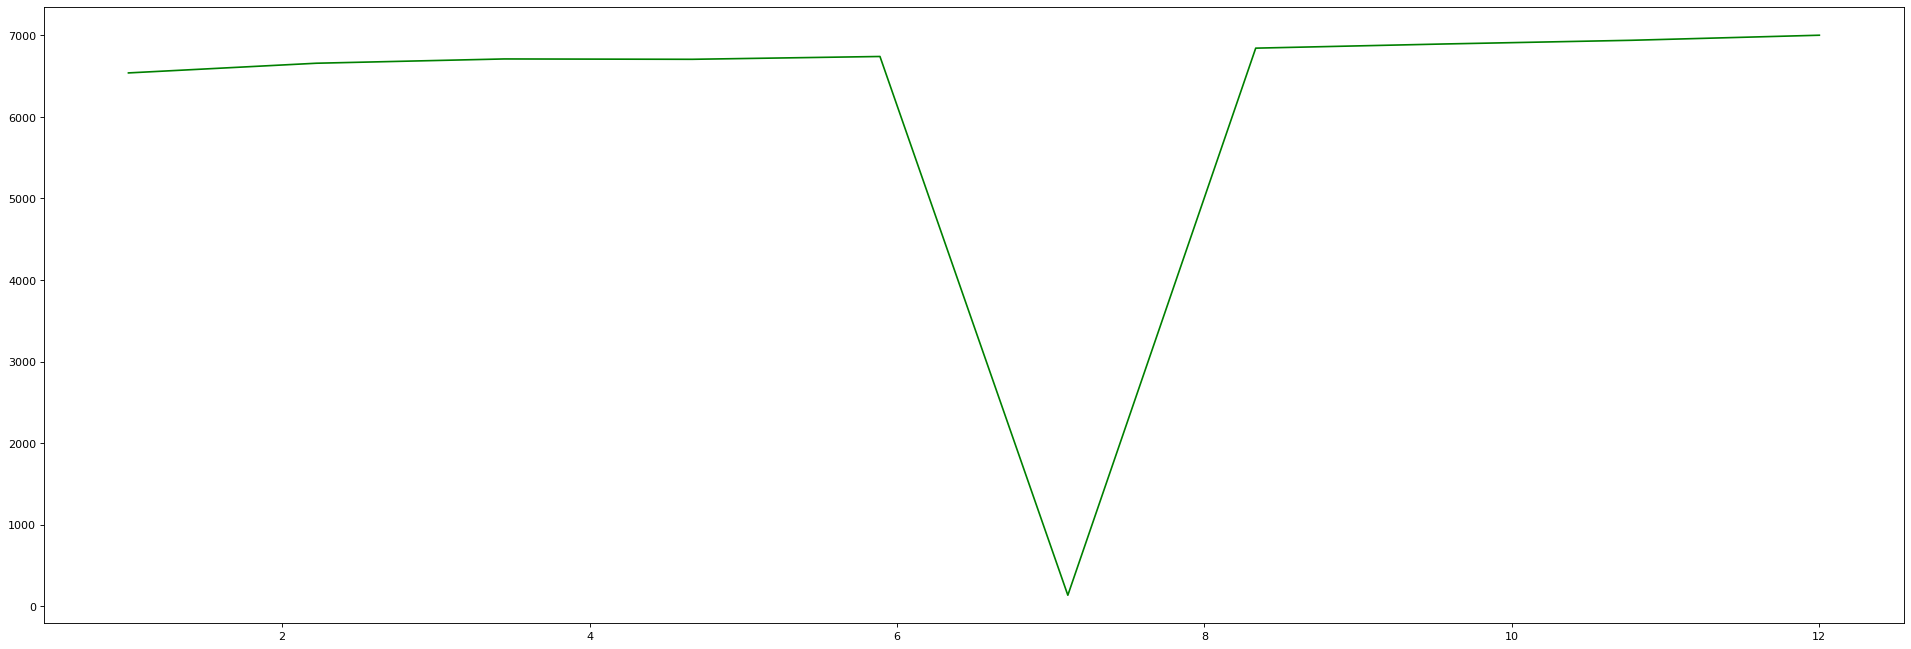

In [11]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成一个等差数列 X，从1到12，共10个点，用于X轴
X = np.linspace(1, 12, 10, endpoint=True)
# 从 DataFrame 的 'value' 列中提取索引33560到33569的数据，并转换为 NumPy 数组
C = np.array(data['value'][33560: 33570])
# 绘制 X 和 C 的折线图，线条颜色设置为绿色
plt.plot(X, C, color='green')
# 显示图表
plt.show()

对序号为33565这条数据，使用其前一个时刻和后一个时刻负荷的平均值代替其的负荷值

In [12]:
# 定位到 DataFrame 中索引为 33565 的 'value' 列
# 将其值更新为索引 33564 和 33566 对应 'value' 列的平均值
# 这是对异常值进行插值处理的一种方法
data.loc[33565, 'value'] = (data.loc[33564]['value'] + data.loc[33566]['value']) / 2

In [13]:
# 显示索引为 33565 的 'value' 列的值，验证更新是否成功
data.loc[33565]['value']

np.float64(6791.646016)

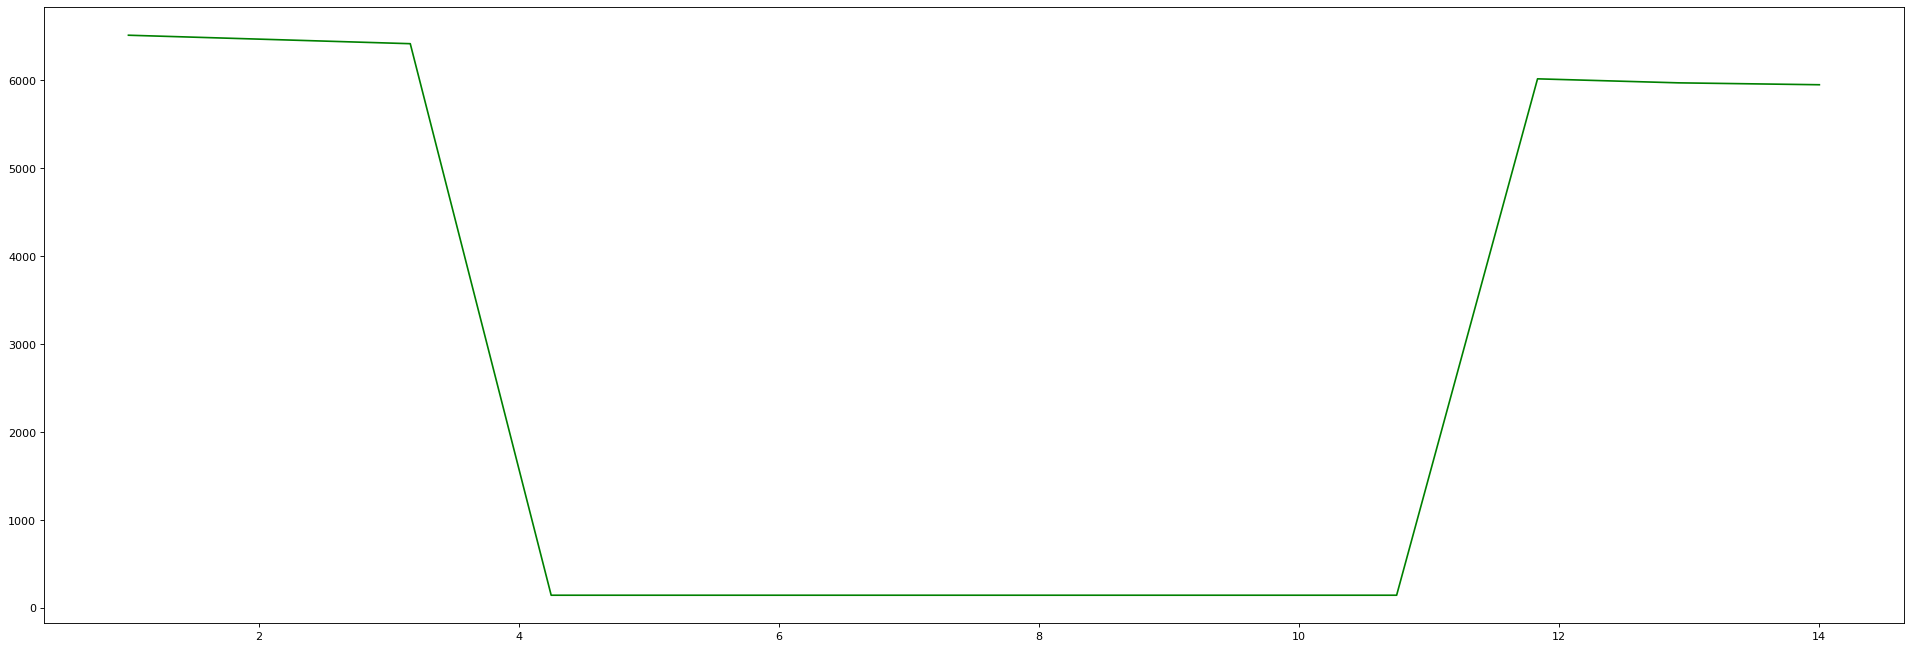

In [14]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成一个等差数列 X，从1到14，共13个点，用于X轴
X = np.linspace(1, 14, 13, endpoint=True)
# 从 DataFrame 的 'value' 列中提取索引60006到60018的数据，并转换为 NumPy 数组
C = np.array(data['value'][60006: 60019])
# 绘制 X 和 C 的折线图，线条颜色设置为绿色
plt.plot(X, C, color='green')
# 显示图表
plt.show()

对序号为60009到60015这7条数据，使用序号为60008和60016数据的负荷的平均值代替他们的负荷值

In [15]:
# 定位到 DataFrame 中索引从 60009 到 60015 的 'value' 列
# 将这些行的 'value' 值更新为索引 60008 和 60016 对应 'value' 列的平均值
# 这是对一段连续异常值进行插值处理的方法
data.loc[60009: 60015, 'value'] = (data.loc[60008]['value'] + data.loc[60016]['value']) / 2

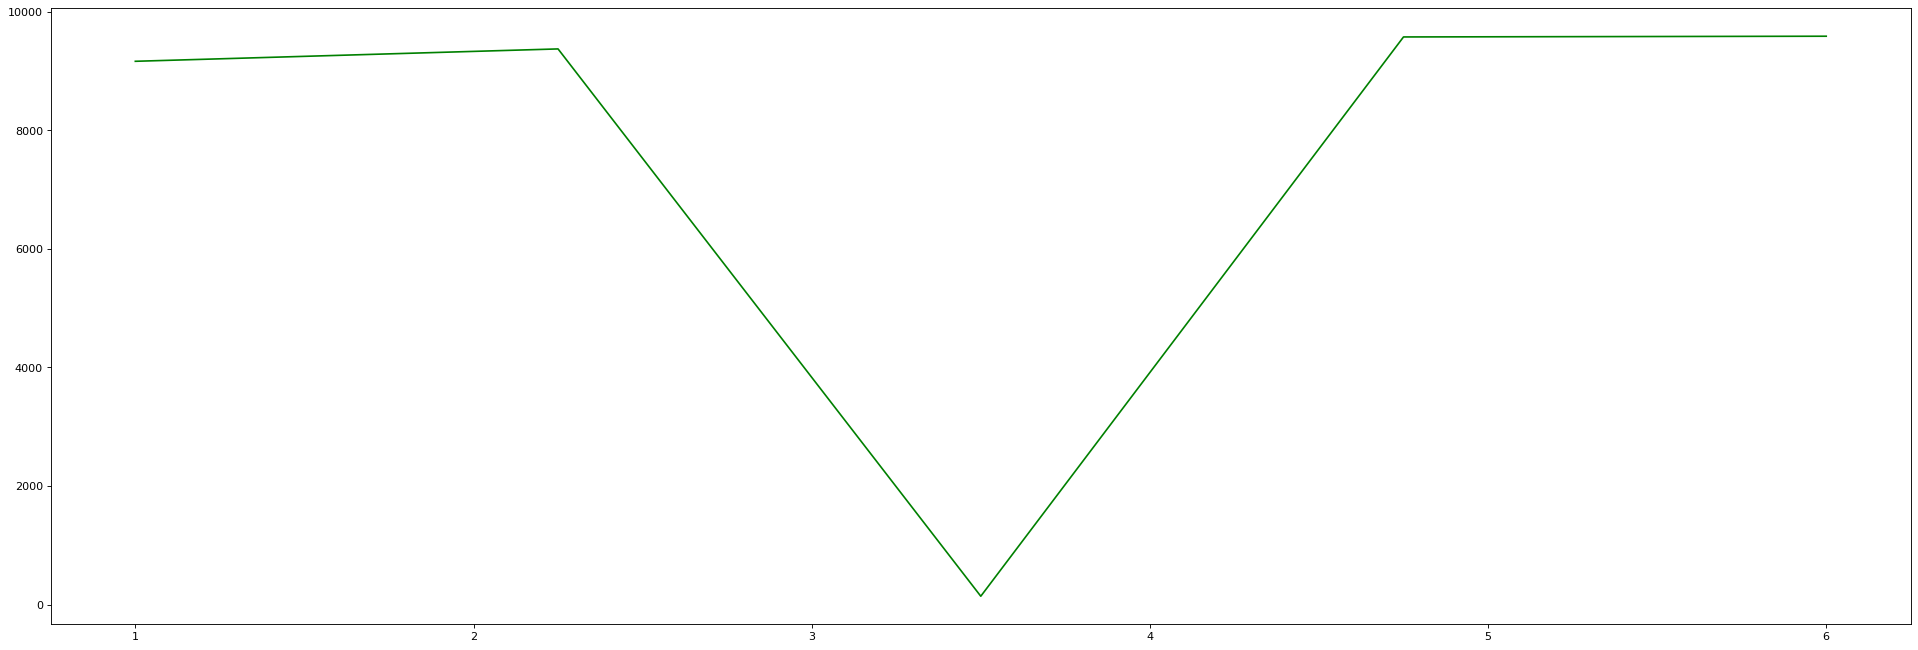

In [16]:
# 创建一个图形，设置图形大小为30x10英寸，DPI为80
plt.figure(figsize=(30, 10), dpi=80)
# 生成一个等差数列 X，从1到6，共5个点，用于X轴
X = np.linspace(1, 6, 5, endpoint=True)
# 从 DataFrame 的 'value' 列中提取索引60055到60059的数据，并转换为 NumPy 数组
C = np.array(data['value'][60055: 60060])
# 绘制 X 和 C 的折线图，线条颜色设置为绿色
plt.plot(X, C, color='green')
# 显示图表
plt.show()


对序号为60057这条数据，使用其前一个时刻和后一个时刻负荷的平均值代替其的负荷值

In [17]:
# 定位到 DataFrame 中索引为 60057 的 'value' 列
# 将其值更新为索引 60056 和 60058 对应 'value' 列的平均值
# 这是对单个异常值进行插值处理的方法
data.loc[60057, 'value'] = (data.loc[60056]['value'] + data.loc[60058]['value']) / 2


In [18]:
# 显示索引为 60057 的 'value' 列的值，验证更新是否成功
data.loc[60057, 'value']

np.float64(9473.481759999999)

将时间分成年、月、日、分钟数，并将一天内的分钟数作为一个特征。

In [19]:
# 将 'time' 列的每个字符串按 '/' 分割，创建列表的列表
list1 = [i.split('/') for i in data['time']]
# 从 list1 的每个子列表中取出最后一个元素（日期和时间部分），再按空格分割
list2 = [i[-1].split(' ') for i in list1]
# 从 list2 的每个子列表中取出最后一个元素（时间部分），再按 ':' 分割
list3 = [i[-1].split(':') for i in list2]
# 计算一天中的总分钟数：小时部分乘以60加上分钟部分
list4 = [int(i[0]) * 60 + int(i[1]) for i in list3]  # 分钟
# 将计算出的分钟数列表转换为 NumPy 数组，并重塑为 (数据长度, 1) 的二维数组
minute = np.array(list4).reshape(len(data), 1)


生成星期特征

In [20]:
# 备注：2021-1-1是周五
# 创建一个空的一维 NumPy 数组，用于存储星期特征，长度与数据量相同
week = np.empty(len(data))
# 打印数据总长度除以 (96 * 7)，96可能代表一天的数据点数（每15分钟一个点，24*4=96），7代表一周
# 检查是否能够整除，即有多少个完整的周
print(len(data)/(96*7))  # 有余数
# 打印数据总长度对 (96 * 7) 取模后再除以 96，计算剩余的天数
print(len(data) % (96*7) // 96)  # 剩余的天数
# 循环遍历完整周的数量
for i in range(len(data)//(96*7)):
    # 计算当前周的起始索引
    m = i * 96 * 7
    # 填充星期特征：周五 (5)
    week[m:m+96] = 5
    # 填充星期特征：周六 (6)
    week[m+96: m+96*2] = 6
    # 填充星期特征：周日 (7)
    week[m+96*2: m+96*3] = 7
    # 填充星期特征：周一 (1)
    week[m+96*3: m+96*4] = 1
    # 填充星期特征：周二 (2)
    week[m+96*4: m+96*5] = 2
    # 填充星期特征：周三 (3)
    week[m+96*5: m+96*6] = 3
    # 填充星期特征：周四 (4)
    week[m+96*6: m+96*7] = 4
# 处理剩余不足一周的数据点，假设它们从周五开始
week[m+96*7: m+96*8] = 5
week[m+96*8: m+96*9] = 6
week[m+96*9: m+96*10] = 7
# 将 week 数组重塑为 (数据长度, 1) 的二维数组
week = week.reshape(len(data), 1)

112.42857142857143
3


In [21]:
# 打印 week 数组的数据类型
week.dtype

dtype('float64')

生成年份特征

In [22]:
# 创建一个空的一维 NumPy 数组，用于存储年份特征，长度与数据量相同
year = np.empty(len(data))
# 填充年份特征：2021年用1表示，对应数据的前 96*365 个点
year[: 96*365] = 1
# 填充年份特征：2022年用2表示，对应数据从 96*365 到 96*365*2 的点
year[96*365: 96*365*2] = 2
# 填充年份特征：2023年用3表示，对应数据从 96*365*2 到末尾的点
year[96*365*2: ] = 3
# 将 year 数组重塑为 (数据长度, 1) 的二维数组
year = year.reshape(len(data), 1)

In [23]:
# 打印 year 数组的数据类型
year.dtype

dtype('float64')

将新特征与原dataframe拼接起来，并删去多余的列

In [24]:
# 使用 numpy 的 concatenate 函数将 minute, week, year 三个特征数组沿列方向（axis=1）拼接起来
array1 = np.concatenate((minute,week,year), axis=1)

In [25]:
# 打印 array1 的形状，即行数和列数，用于验证拼接结果
array1.shape

(75552, 3)

In [26]:
# 将 array1 转换为 Pandas DataFrame，并指定列名为 'minute', 'week', 'year'
df_1 = pd.DataFrame(array1, columns=['minute', 'week', 'year'])

In [27]:
# 将原始数据 DataFrame (data) 与新生成的特征 DataFrame (df_1) 沿列方向（axis=1）拼接起来
# 并删除不再需要的列：'Unnamed: 0'（通常是读取CSV时产生的额外索引列）、'wind_direction' 和 'time'
new_data = pd.concat((data, df_1), axis=1).drop(['Unnamed: 0', 'wind_direction', 'time'], axis=1)

In [28]:
# 显示处理后的 new_data DataFrame 的前几行，用于快速查看新的数据结构
new_data

,value,weather_status,temperature,humidity,wind_speed,wind_level,wind_direction_angle,pressure,visibility,precipitation,light,holiday,minute,week,year
0,3210.842464,1,'-8.6','41','0.5','0','359','977','9.7','0','0',1.0,0.0,5.0,1.0
1,3104.507008,1,'-8.88','43.00','0.5','0','359','977','9.7','0','0',1.0,15.0,5.0,1.0
2,3037.705984,1,'-9.16','45.00','0.5','0','359','977','9.7','0','0',1.0,30.0,5.0,1.0
3,2960.176288,1,'-9.44','47.00','0.5','0','359','977','9.7','0','0',1.0,45.0,5.0,1.0
4,2889.226528,3,'-9.7','49','0.7','0','335','976','8.6','0','0',1.0,60.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75547,5649.941920,1,'5.85','64.75','1.6','17','250','976','5.2','0','0',0.0,1365.0,7.0,3.0
75548,5451.523744,1,'5.5','66','1','0','124','976','4.6','0','0',0.0,1380.0,7.0,3.0
75549,5246.500000,1,'5.15','67.25','1','0','124','976','4.6','0','0',0.0,1395.0,7.0,3.0
75550,5039.924704,1,'4.80','68.50','1','0','124','976','4.6','0','0',0.0,1410.0,7.0,3.0


In [29]:
# 打印 new_data DataFrame 的信息摘要，包括每列的非空值数量和数据类型，以及内存使用情况
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float64
 1   weather_status        75552 non-null  int64  
 2   temperature           75552 non-null  object 
 3   humidity              75552 non-null  object 
 4   wind_speed            75552 non-null  object 
 5   wind_level            75552 non-null  object 
 6   wind_direction_angle  75552 non-null  object 
 7   pressure              75552 non-null  object 
 8   visibility            75552 non-null  object 
 9   precipitation         75552 non-null  object 
 10  light                 75552 non-null  object 
 11  holiday               75552 non-null  float64
 12  minute                75552 non-null  float64
 13  week                  75552 non-null  float64
 14  year                  75552 non-null  float64
dtypes: float64(5), int6

将object类型数据两边的引号去掉，然后转为数值类型

In [30]:
# 从 new_data 中选择特定的气象特征列，创建新的 DataFrame df_2
df_2 = new_data[['temperature', 'humidity', 'wind_speed', 'wind_level', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light']]

In [31]:
# 显示 df_2 DataFrame 的前几行，用于检查其内容
df_2

,temperature,humidity,wind_speed,wind_level,wind_direction_angle,pressure,visibility,precipitation,light
0,'-8.6','41','0.5','0','359','977','9.7','0','0'
1,'-8.88','43.00','0.5','0','359','977','9.7','0','0'
2,'-9.16','45.00','0.5','0','359','977','9.7','0','0'
3,'-9.44','47.00','0.5','0','359','977','9.7','0','0'
4,'-9.7','49','0.7','0','335','976','8.6','0','0'
...,...,...,...,...,...,...,...,...,...
75547,'5.85','64.75','1.6','17','250','976','5.2','0','0'
75548,'5.5','66','1','0','124','976','4.6','0','0'
75549,'5.15','67.25','1','0','124','976','4.6','0','0'
75550,'4.80','68.50','1','0','124','976','4.6','0','0'


In [32]:
# 将 df_2 转换为 NumPy 数组 array2
array2 = np.array(df_2)

In [33]:
# 遍历 array2 的每一列（共9列）
for i in range(9):
    # 对当前列中的每个元素，去除字符串两端的引号（从索引1到倒数第二个字符）
    a = [j[1: -1] for j in array2[:, i]]
    # 将处理后的字符串列表转换为数值类型 (Pandas Series)，也可使用 float() 函数逐个转换
    a = pd.to_numeric(a)  # 也可使用float()
    # 将转换后的数值重新赋值回 array2 的当前列
    array2[:, i] = a

In [34]:
# 将 array2 数组的数据类型转换为 32 位浮点型 (float32)
array2 = array2.astype(dtype=np.float32)

新的dataframe

In [35]:
# 将处理后的 array2 数组（包含数值化的气象特征）重新赋值给 new_data DataFrame 的相应列
new_data[['temperature', 'humidity', 'wind_speed', 'wind_level', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light']] = array2

In [36]:
# 打印 new_data DataFrame 的信息摘要，再次检查数据类型是否已更新为数值类型
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float64
 1   weather_status        75552 non-null  int64  
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_level            75552 non-null  float32
 6   wind_direction_angle  75552 non-null  float32
 7   pressure              75552 non-null  float32
 8   visibility            75552 non-null  float32
 9   precipitation         75552 non-null  float32
 10  light                 75552 non-null  float32
 11  holiday               75552 non-null  float64
 12  minute                75552 non-null  float64
 13  week                  75552 non-null  float64
 14  year                  75552 non-null  float64
dtypes: float32(9), floa

In [37]:
# 将整个 new_data DataFrame 的数据类型统一转换为 32 位浮点型 (float32)
new_data = new_data.astype(np.float32)

In [38]:
# 再次打印 new_data DataFrame 的信息摘要，确认所有列的数据类型都已是 float32
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float32
 1   weather_status        75552 non-null  float32
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_level            75552 non-null  float32
 6   wind_direction_angle  75552 non-null  float32
 7   pressure              75552 non-null  float32
 8   visibility            75552 non-null  float32
 9   precipitation         75552 non-null  float32
 10  light                 75552 non-null  float32
 11  holiday               75552 non-null  float32
 12  minute                75552 non-null  float32
 13  week                  75552 non-null  float32
 14  year                  75552 non-null  float32
dtypes: float32(15)
memo

查看气象特征的数值分布，看看有没有异常值

In [39]:
# 对 'weather_status' 列进行升序排序，并显示所有排序后的值
# 用于检查天气状态的数值分布，看是否有异常值或不一致的编码
new_data['weather_status'].sort_values()  # 天气状态

,weather_status
75551,1.0
75550,1.0
75549,1.0
75548,1.0
75547,1.0
...,...
7116,23.0
7111,23.0
7112,23.0
7113,23.0


In [40]:
# 统计 'weather_status' 列中每个唯一值的出现次数
# 用于了解不同天气状态的分布情况
new_data['weather_status'].value_counts()  # 天气状态

,count
weather_status,
1.0,35216
2.0,15152
3.0,14548
11.0,3272
7.0,2776
19.0,2292
21.0,808
16.0,556
20.0,436


In [41]:
new_data['temperature'].sort_values()  # 温度

,temperature
604,-14.600000
605,-14.570000
603,-14.540000
606,-14.540000
607,-14.510000
...,...
51811,40.759998
51810,40.840000
51807,40.849998
51809,40.919998


In [42]:
new_data['humidity'].sort_values()  # 湿度

,humidity
12099,6.0
12095,6.0
12097,6.0
12092,6.0
12103,6.0
...,...
54540,100.0
54539,100.0
57139,100.0
57140,100.0


In [43]:
new_data['wind_speed'].sort_values()  # 风速

,wind_speed
26780,0.0
27823,0.0
27822,0.0
27821,0.0
18119,0.0
...,...
590,9.2
593,13.3
595,13.3
594,13.3


In [44]:
new_data['wind_level'].sort_values()  # 风力等级

,wind_level
75550,0.0
75549,0.0
75548,0.0
15,0.0
14,0.0
...,...
24,17.0
23,17.0
22,17.0
21,17.0


In [45]:
new_data['wind_level'].value_counts()  # 风力等级

,count
wind_level,
17.0,29791
0.0,23249
1.0,22296
2.0,212
3.0,4


In [46]:
new_data['wind_direction_angle'].sort_values()  # 风向角

,wind_direction_angle
13345,0.0
13344,0.0
13347,0.0
13346,0.0
29459,0.0
...,...
66178,360.0
66177,360.0
66176,360.0
3065,360.0


In [47]:
new_data['pressure'].sort_values()  # 压力

,pressure
43008,857.0
43009,857.0
43010,857.0
43011,857.0
42993,861.0
...,...
42996,1008.0
44308,1018.0
44309,1018.0
44311,1018.0


In [48]:
new_data['visibility'].sort_values()  # 可见度

,visibility
26221,0.1
26220,0.1
26223,0.1
26222,0.1
26228,0.1
...,...
39275,30.0
39276,30.0
39277,30.0
39278,30.0


In [49]:
new_data['visibility'].value_counts()  # 可见度

,count
visibility,
30.0,9720
6.4,1992
14.4,1492
12.2,588
5.4,512
...,...
0.6,16
0.4,16
0.3,12


In [50]:
new_data['precipitation'].sort_values()  # 降水

,precipitation
49744,0.000000
49753,0.000000
49752,0.000000
49751,0.000000
49750,0.000000
...,...
53872,15.200000
53869,34.599998
53870,34.599998
53868,34.599998


In [51]:
new_data['light'].sort_values()  # 光照强度

,light
31669,0.000000
31679,0.000000
31678,0.000000
31677,0.000000
31676,0.000000
...,...
14163,998.409973
49393,999.203369
49392,999.203369
49395,999.203369


气象数据未发现异常值。

风速和风力等级重复了，并且这个数据集里风力等级只有0，1，2，3，17这5种取值，所以删去风力等级(wind_level)列。

In [52]:
# 从 new_data DataFrame 中删除 'wind_level' 列，axis=1 表示按列删除
new_data = new_data.drop('wind_level', axis=1)

In [53]:
# 再次打印 new_data DataFrame 的信息摘要，确认 'wind_level' 列已被成功删除
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float32
 1   weather_status        75552 non-null  float32
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_direction_angle  75552 non-null  float32
 6   pressure              75552 non-null  float32
 7   visibility            75552 non-null  float32
 8   precipitation         75552 non-null  float32
 9   light                 75552 non-null  float32
 10  holiday               75552 non-null  float32
 11  minute                75552 non-null  float32
 12  week                  75552 non-null  float32
 13  year                  75552 non-null  float32
dtypes: float32(14)
memory usage: 4.0 MB


将new_data保存起来

In [54]:
# 将处理后的 new_data DataFrame 保存为 CSV 文件
# 文件名为 'new_data.csv'，不包含索引列
new_data.to_csv('new_data.csv')

划分训练集和测试集，2021年和2022年的数据作为训练集，2023年的数据作为测试集

In [55]:
# 可以之后再将2021、2022的数据和2023的部分数据作为训练

In [56]:
# 根据索引将 new_data 划分为训练集和测试集
# 训练集 train 包含从开始到索引 70079 的数据
train = new_data.loc[:70079]
# 测试集 test 包含从索引 70080 到末尾的数据
test = new_data.loc[70080:]


In [57]:
# 打印训练集的数据行数
print(len(train))
# 打印测试集的数据行数
print(len(test))


70080
5472


对训练集数据归一化

In [58]:
# 实例化 MinMaxScaler，用于将数据缩放到 [0, 1] 范围
scaler = MinMaxScaler()
# 使用训练集数据拟合 MinMaxScaler，计算出数据的最小值和最大值
# fit 方法在这里的本质是根据 train 数据生成归一化所需的min(x)和max(x)
scaler = scaler.fit(train)
# 使用拟合好的 scaler 对训练集数据进行归一化转换
# 结果 train_result 是一个 NumPy 数组 (ndarray) 类型
train_result = scaler.transform(train)

In [59]:
# 显示 scaler 对象本身，它包含了归一化的参数（如 min_、scale_ 等）
scaler

MinMaxScaler()

In [60]:
# 打印归一化后训练集数据 train_result 的形状
train_result.shape

(70080, 14)

生成训练数据

In [61]:
# 定义一个函数 create_inout_sequences，用于生成输入-输出序列
# input_data: 输入的原始数据（已归一化）
# tw: 时间窗口大小 (time window)，即每个序列的长度
def create_inout_sequences(input_data, tw):
    # 初始化一个空列表，用于存储生成的输入-输出序列对
    inout_seq = []
    # 获取输入数据的总长度
    L = len(input_data)
    # 循环生成序列，直到数据末尾
    for i in range(L - tw + 1):
        # 深度复制当前时间窗口的数据作为训练输入序列
        train_seq = copy.deepcopy(input_data[i:i + tw])
        # 将输入序列中从第96个时刻开始到 tw 结束的负荷值（第0列）设为1
        # 这可能表示预测时刻的负荷值用占位符1表示，实际含义是未知
        train_seq[96:tw, 0] = 1
        # 提取从第96个时刻开始到 tw 结束的负荷值（第0列）作为训练标签
        train_label = input_data[i + 96:i + tw, 0]
        # 将输入序列和对应的标签转换为 PyTorch 张量，并作为一个元组添加到列表中
        inout_seq.append((torch.tensor(train_seq), torch.tensor(train_label)))
    # 返回所有生成的输入-输出序列对
    return inout_seq

In [62]:
# 调用 create_inout_sequences 函数，使用归一化后的训练集数据 train_result 和时间窗口 192 (96+96)
# 生成用于模型训练的输入-输出序列
train_inout_seq = create_inout_sequences(train_result, 192)

In [63]:
# 打印 train_inout_seq 列表中包含的序列对的数量
len(train_inout_seq)

69889

训练样本的数量为69889，每个训练样本包括特征和标签，其中特征为前96个时刻和后96个时刻的气象数据和负荷值（后96个时刻的负荷值用1代替，只是占个位置，保证输入序列的特征数一致，没有实际含义），标签为后96个时刻的负荷值。

使用前24小时和未来24小时的数据预测未来24小时的负荷

设置批量大小为96

In [64]:
trainloader = torch.utils.data.DataLoader(train_inout_seq, batch_size=96, shuffle=True)

In [65]:
len(trainloader)

729

In [66]:
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)

torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([9

### 建立LSTM模型并训练

In [67]:
class LstmNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.LSTM(14, 60, 1, batch_first=True)  # 这个lstm的输入为15个神经元，隐藏层的输出为50个神经元，每个训练样本一次训练这个lstm被重复执行了49次，
        self.layer2 = nn.Linear(60, 1)  # 或者形象地说这个lstm结构在时间上的长度为49。

    def forward(self, x):
        y1, _ = self.layer1(x)
        y1 = y1[:, -96:, :]
        y2 = self.layer2(y1)
        return y2.reshape(-1, 96)

In [68]:
49*1*15; 15*50; 49*1*50; 49*50; 50*1; 49*1  # 批量大小为1
49*64*15; 15*50; 49*64*50; 50*1; 49*64*1  # 批量大小为64
192*1*15; 15*50; 192*1*50; 96*1*50; 96*50; 50*1; 96*1

96

In [69]:
96*192*15
15*50
96*192*50
96*96*50
50*1
96*96*1
96*96  # 批量大小为96，batch_first=True

9216

In [70]:
lstmnet = LstmNet()

In [71]:
lr = 0.001
opt = optim.Adam(lstmnet.parameters(), lr=lr)

In [72]:
loss_function = nn.MSELoss()  # 方差/平均平方误差

In [73]:
# 刚开始使用学习率为0.01训练，损失下降到0.001左右时，开始波动比较大，损失没有什么下降，然后使用学习率为0.003训练，然后使用学习率0.001训练。
# 得到的损失最小值为0.0003左右。

In [74]:
epochs = 1
for epoch in range(epochs):
    i = 0
    all_loss = 0
    for xb, yb in trainloader:
        y = lstmnet(xb)
        loss = loss_function(y, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        all_loss += loss.data
        if i%10 == 0:
            print(loss.data)
    print('损失:')
    print(all_loss / len(trainloader))

tensor(0.1217)
tensor(0.0604)
tensor(0.0316)
tensor(0.0266)
tensor(0.0294)
tensor(0.0268)
tensor(0.0218)
tensor(0.0274)
tensor(0.0169)
tensor(0.0177)
tensor(0.0171)
tensor(0.0176)
tensor(0.0153)
tensor(0.0186)
tensor(0.0170)
tensor(0.0173)
tensor(0.0175)
tensor(0.0188)
tensor(0.0203)
tensor(0.0238)
tensor(0.0187)
tensor(0.0178)
tensor(0.0153)
tensor(0.0158)
tensor(0.0168)
tensor(0.0241)
tensor(0.0135)
tensor(0.0172)
tensor(0.0167)
tensor(0.0170)
tensor(0.0162)
tensor(0.0175)
tensor(0.0154)
tensor(0.0162)
tensor(0.0150)
tensor(0.0190)
tensor(0.0170)
tensor(0.0157)
tensor(0.0164)
tensor(0.0156)
tensor(0.0139)
tensor(0.0165)
tensor(0.0148)
tensor(0.0141)
tensor(0.0152)
tensor(0.0170)
tensor(0.0142)
tensor(0.0119)
tensor(0.0141)
tensor(0.0136)
tensor(0.0112)
tensor(0.0132)
tensor(0.0103)
tensor(0.0112)
tensor(0.0105)
tensor(0.0134)
tensor(0.0136)
tensor(0.0109)
tensor(0.0144)
tensor(0.0101)
tensor(0.0144)
tensor(0.0134)
tensor(0.0103)
tensor(0.0109)
tensor(0.0111)
tensor(0.0127)
tensor(0.0

### 预测

解决v_max v_min 未定义问题

In [75]:
v_max = max(train['value'])
v_min = min(train['value'])

In [76]:
(300 / (v_max - v_min)) ** 2

0.0011182993634812012

In [77]:
(100 / (v_max - v_min)) ** 2

0.00012425548483124458

In [78]:
test_result = scaler.transform(test)

生成测试数据

In [79]:
test_seq = create_inout_sequences(test_result, 192)

In [80]:
len(test_seq)

5281

预测测试集里的某一样本

In [81]:
v_max = max(train['value'])
v_min = min(train['value'])

In [82]:
pred = lstmnet(test_seq[1000][0].reshape(1, 192, 14))

In [83]:
pred

tensor([[0.7094, 0.7152, 0.7180, 0.7192, 0.7236, 0.7247, 0.7251, 0.7257, 0.7402,
         0.7414, 0.7388, 0.7340, 0.7193, 0.7168, 0.7172, 0.7192, 0.7187, 0.7172,
         0.7164, 0.7173, 0.7160, 0.7192, 0.7239, 0.7290, 0.7291, 0.7352, 0.7422,
         0.7486, 0.7471, 0.7456, 0.7449, 0.7456, 0.7466, 0.7493, 0.7531, 0.7573,
         0.7653, 0.7741, 0.7812, 0.7861, 0.7894, 0.7908, 0.7909, 0.7901, 0.7878,
         0.7848, 0.7814, 0.7775, 0.7756, 0.7674, 0.7568, 0.7446, 0.7313, 0.7177,
         0.7037, 0.6895, 0.6247, 0.5852, 0.5566, 0.5343, 0.5182, 0.5028, 0.4888,
         0.4758, 0.4643, 0.4535, 0.4438, 0.4353, 0.4270, 0.4221, 0.4207, 0.4234,
         0.4355, 0.4461, 0.4612, 0.4810, 0.5052, 0.5323, 0.5610, 0.5902, 0.6186,
         0.6457, 0.6702, 0.6916, 0.7081, 0.7226, 0.7337, 0.7413, 0.7498, 0.7538,
         0.7549, 0.7541, 0.7569, 0.7555, 0.7526, 0.7494]],
       grad_fn=<ViewBackward0>)

In [84]:
test_seq[1000][1]

tensor([0.7438, 0.7479, 0.7525, 0.7546, 0.7566, 0.7574, 0.7340, 0.6965, 0.6058,
        0.5454, 0.5497, 0.5459, 0.5520, 0.5751, 0.6282, 0.6901, 0.7053, 0.7180,
        0.7231, 0.7245, 0.7289, 0.7326, 0.7373, 0.7423, 0.7494, 0.7569, 0.7621,
        0.7644, 0.7519, 0.7399, 0.6878, 0.6572, 0.6601, 0.6830, 0.7160, 0.7424,
        0.7512, 0.7533, 0.7480, 0.7448, 0.7371, 0.7361, 0.7352, 0.7323, 0.7238,
        0.7156, 0.7050, 0.6902, 0.6684, 0.6499, 0.6277, 0.6015, 0.5719, 0.5347,
        0.5085, 0.4784, 0.4558, 0.4380, 0.4276, 0.4187, 0.4123, 0.4054, 0.4012,
        0.3985, 0.3931, 0.3883, 0.3853, 0.3809, 0.3779, 0.3724, 0.3692, 0.3671,
        0.3663, 0.3658, 0.3635, 0.3650, 0.3642, 0.3646, 0.3648, 0.3666, 0.3673,
        0.3725, 0.3763, 0.3835, 0.3991, 0.4210, 0.4496, 0.4904, 0.5608, 0.6409,
        0.6738, 0.6920, 0.7003, 0.7079, 0.7155, 0.7194])

In [85]:
true_label = test_seq[1000][1] * (v_max - v_min) + v_min
true_label = true_label.detach().numpy()

In [86]:
true_pred = pred * (v_max - v_min) + v_min
true_pred = true_pred.reshape(96)
true_pred = true_pred.detach().numpy()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


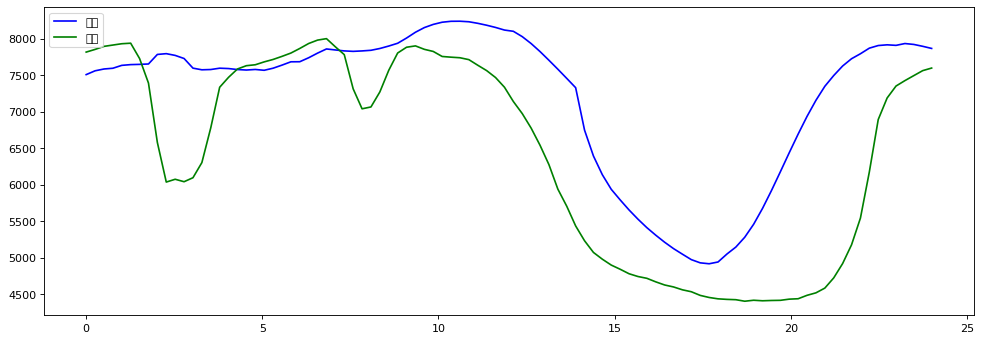

In [87]:
plt.rc('font',family='DengXian')
plt.figure(figsize=(15, 5), dpi=80)

X = np.linspace(0, 24, 96, endpoint=True)
C,S = true_pred, true_label
plt.plot(X, C, color='blue', label='预测')
plt.plot(X, S, color='green', label='真实')
plt.legend(loc='upper left')
plt.show()

采用绝对百分比误差（APE）对模型的预测准确度进行评价

单个样本的APE：|y预测 - y真实| ÷ y真实 × 100%

In [88]:
def APE_list(test_seq):  # 预测的每个24小时的平均APE组成的列表
    list1 = []
    for i in test_seq:
        pred = lstmnet(i[0].reshape(1, 192, 14))
        true_label = i[1] * (v_max - v_min) + v_min
        true_label = true_label.detach().numpy()
        true_pred = pred * (v_max - v_min) + v_min
        true_pred = true_pred.reshape(96)
        true_pred = true_pred.detach().numpy()
        num = sum(abs(true_pred - true_label) / true_label) / 96
        list1.append(num)

    return list1
#max(list1), min(list1)，list1.index()

在训练数据上的APE(随机选取5000个样本)

In [89]:
train_samples = random.sample(train_inout_seq, 5000)
list1 = APE_list(train_samples)
str(sum(list1) / len(list1) * 100) + '%'

'19.836512%'

In [90]:
print("2.2772615524194593%")
print("2.206285492008685%")

2.2772615524194593%
2.206285492008685%


训练数据5000个样本的APE分布的箱线图

<Axes: >

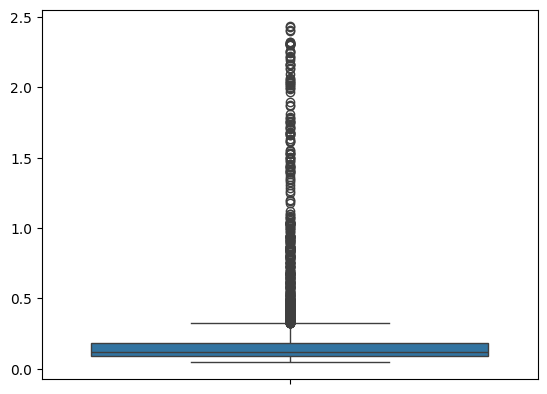

In [91]:
sns.boxplot(data=list1)

(0.0, 0.1)

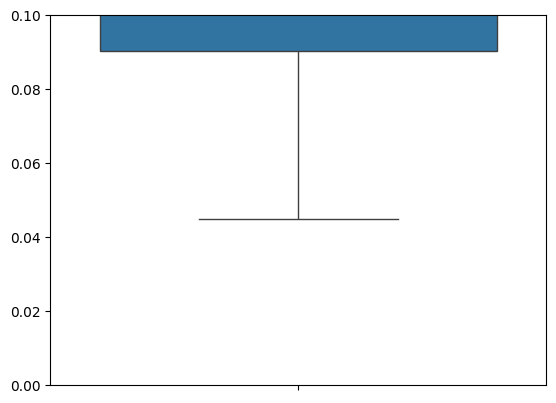

In [92]:
sns.boxplot(data=list1)
plt.ylim(0, 0.1)

在测试数据上的APE

In [93]:
list2 = APE_list(test_seq)
str(sum(list2) / len(list2) * 100) + '%'

'60.24205%'

In [94]:
# 12.82968216754979%
# 11.554603512965041%
# 10.827513699236222%  保存了模型参数
# 12.067778039869548%
# 11.134349473801382%
# 12.187801521781639%
# 13.075773991825642%
# 11.319367309684035%
# 12.772845299314422%
# 12.93004775791501%
# 12.542951042622278%

测试数据的APE分布的箱线图

<Axes: >

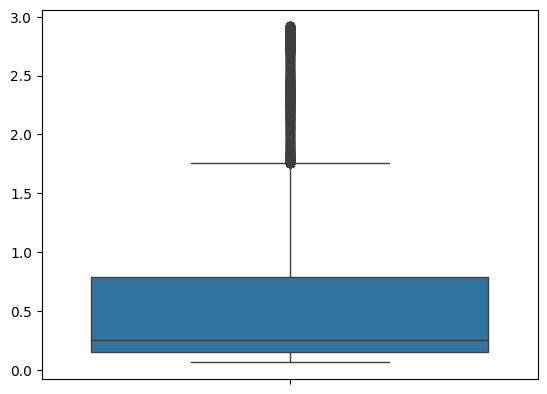

In [95]:
sns.boxplot(data=list2)

(0.0, 0.4)

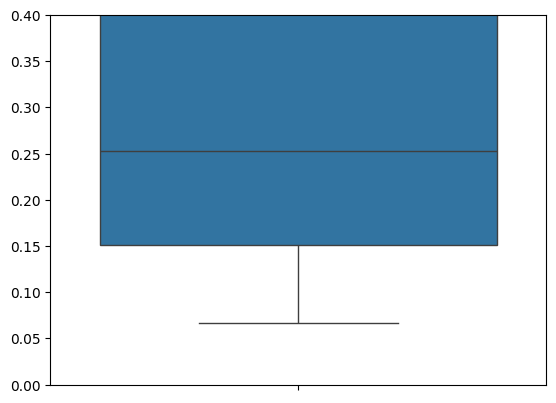

In [96]:
sns.boxplot(data=list2)
plt.ylim(0, 0.4)

In [97]:
min(list2)

np.float32(0.0664384)

In [98]:
max(list2)

np.float32(2.9173777)

In [99]:
torch.save(lstmnet.state_dict(), '/content/gdrive/MyDrive/ElectricPowerTraining/code/lstmnet_2_5_1.pt')

之后可和全连接神经网络的性能做个对比